# import library

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# merge data

In [ ]:
data_path = '/home/agung/Documents/alcr/ABC2026 Sozolab Challenge-20260110T085845Z-1-001/ABC2026 Sozolab Challenge/Dataset/BLE Data'

file_name = '4 day'

rssi_list = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16', '17','18','19','20', '21','22', '23','24','25']

mac_list = ['F7:7F:78:76:7E:F3',
            'C6:CD:5E:3D:2F:BB',
            'D6:F4:3A:79:74:63',
            'C9:17:55:E2:3E:0E',
            'CA:60:AB:EE:EC:7F',
            'D6:51:7F:AB:0E:29',
            'CC:54:33:F6:A7:90',
            'EB:20:56:87:04:5A',
            'EE:E7:46:DC:19:6F',
            'C8:5B:BF:37:07:A0',
            'D7:26:F6:A3:44:D2',
            'DD:83:B0:27:FD:36',
            'E5:CD:4A:36:87:06',
            'DC:22:B8:17:4E:B5',
            'EA:09:20:80:D6:44',
            'E6:99:D1:EC:C6:81',
            'F6:DA:97:C7:D5:28',
            'EA:66:A1:12:2C:F4',
            'C9:EA:57:8B:0F:80',
            'D6:7C:1D:2C:2A:0A',
            'DA:E1:70:5F:44:97',
            'DD:10:10:F6:4F:27',
            'E6:F3:93:A8:9E:22',
            'E6:60:05:1F:88:F9',
            'D4:33:FD:F4:C2:A8']

file_list = os.listdir(data_path)

csv_data = []
for csv_file in file_list:
  csv_data.append(pd.read_csv(os.path.join(data_path,csv_file),names=['user_id','timestamp','name', 'mac address', 'RSSI', 'power']))

df = csv_data[0]
for i in range(1,len(csv_data)):
  df = pd.concat([df,csv_data[i]])

print(df.shape)
df.head(5)

In [ ]:
# df.to_csv('df_concatenated.csv', index=False)

# load data

In [ ]:
df = pd.read_csv('../../dataset/df_concatenated.csv')
label = pd.read_csv('../../dataset/Dataset/5f_label_loc_train.csv')

# eda

In [ ]:
print(df.info())

print(label.info())

## rssi

In [ ]:
df.head(1)

In [ ]:
print(df['user_id'].value_counts())
print(df['name'].value_counts())

In [ ]:
print(df['mac address'].nunique())
print(df['power'].nunique())
print(df['RSSI'].nunique())

In [ ]:
plt.hist(df['power'])

In [ ]:
plt.hist(df['RSSI'])

## label

In [ ]:
label.head(1)

In [ ]:
print(label['activity'].value_counts())
print(label['user_id'].value_counts())
print(label['user'].value_counts())
print(label['room'].value_counts())
print(label['floor'].value_counts())

# preprocessing

## cleaning

In [ ]:
df = df.drop(columns=['name'])

label = label.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'user', 'floor'])

In [ ]:
# rename agar jelas
label = label.rename(columns={
    'started_at': 'start_time',
    'finished_at': 'stop_time'
})

# parse waktu
label['start_time'] = pd.to_datetime(label['start_time'], errors='coerce')
label['stop_time']  = pd.to_datetime(label['stop_time'], errors='coerce')

# hitung durasi
label['duration'] = (label['stop_time'] - label['start_time']).dt.total_seconds()

# filter valid
label = label[
    label['start_time'].notna() &
    label['stop_time'].notna() &
    (label['duration'] > 0) &
    label['deleted_at'].isna()
]

# hapus null penting & duplikat
label = label.dropna(subset=['room'])
label = label.drop_duplicates()

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notna()]

In [ ]:
df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Tokyo')
label['start_time'] = label['start_time'].dt.tz_convert('Asia/Tokyo')
label['stop_time'] = label['stop_time'].dt.tz_convert('Asia/Tokyo')

In [ ]:
label = label.loc[label['activity'] == 'Location']
label = label.drop(columns=['deleted_at', 'updated_at', 'activity'])

In [ ]:
df = df.sort_values('timestamp').reset_index(drop=True)
label = label.sort_values('start_time').reset_index(drop=True)

In [ ]:
# ambil rentang label
start_label = label['start_time'].min()
end_label = label['stop_time'].max()

# potong RSSI ke rentang label
df = df[(df['timestamp'] >= start_label) & (df['timestamp'] <= end_label)].copy()

print(df['timestamp'].min(), df['timestamp'].max())

In [ ]:
print(start_label)
print(end_label)

In [ ]:
rooms = []
lbl = label.to_dict('records')
j = 0
n = len(lbl)

for ts in df['timestamp']:
    # geser interval label sampai stop_time >= ts
    while j < n and ts > lbl[j]['stop_time']:
        j += 1

    if j < n and lbl[j]['start_time'] <= ts <= lbl[j]['stop_time']:
        rooms.append(lbl[j]['room'])
    else:
        rooms.append(np.nan)

df['room'] = rooms

# buang RSSI tanpa label
df1 = df.dropna(subset=['room']).reset_index(drop=True)


In [ ]:
print(df1.shape)
print(df1['room'].value_counts())

In [ ]:
df1.info()

In [ ]:
df1.to_csv('../../dataset/df_cleaned.csv')

## feature engineering

In [2]:
df = pd.read_csv('../../Dataset/df_cleaned.csv')

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df[df['timestamp'].notna()]
df = df.drop(columns=['Unnamed: 0'])

In [4]:
mac_list = ['F7:7F:78:76:7E:F3',
            'C6:CD:5E:3D:2F:BB',
            'D6:F4:3A:79:74:63',
            'C9:17:55:E2:3E:0E',
            'CA:60:AB:EE:EC:7F',
            'D6:51:7F:AB:0E:29',
            'CC:54:33:F6:A7:90',
            'EB:20:56:87:04:5A',
            'EE:E7:46:DC:19:6F',
            'C8:5B:BF:37:07:A0',
            'D7:26:F6:A3:44:D2',
            'DD:83:B0:27:FD:36',
            'E5:CD:4A:36:87:06',
            'DC:22:B8:17:4E:B5',
            'EA:09:20:80:D6:44',
            'E6:99:D1:EC:C6:81',
            'F6:DA:97:C7:D5:28',
            'EA:66:A1:12:2C:F4',
            'C9:EA:57:8B:0F:80',
            'D6:7C:1D:2C:2A:0A',
            'DA:E1:70:5F:44:97',
            'DD:10:10:F6:4F:27',
            'E6:F3:93:A8:9E:22',
            'E6:60:05:1F:88:F9',
            'D4:33:FD:F4:C2:A8']

df = df[df['mac address'].isin(mac_list)]
df = df.sort_values('timestamp').reset_index(drop=True)

In [5]:
WINDOW = '45s'
df['window_start'] = df['timestamp'].dt.floor(WINDOW)

room_per_window = (
    df.groupby('window_start')['room']
      .nunique()
      .value_counts()
)

room_per_window

room
1    729
2    175
3     35
4      4
5      1
Name: count, dtype: int64

In [6]:
valid_windows = (
    df.groupby('window_start')['room']
      .nunique()
      .reset_index()
)

valid_windows = valid_windows[valid_windows['room'] == 1]['window_start']

df = df[df['window_start'].isin(valid_windows)].reset_index(drop=True)

df.groupby('window_start')['room'].nunique().value_counts()

room
1    729
Name: count, dtype: int64

In [7]:
# RSSI matrix: window x beacon
rssi_matrix = (
    df
    .groupby(['window_start', 'mac address'])['RSSI']
    .mean()              
    .unstack('mac address')
    .sort_index()
)

In [8]:
rssi_matrix

mac address,C6:CD:5E:3D:2F:BB,C8:5B:BF:37:07:A0,C9:17:55:E2:3E:0E,C9:EA:57:8B:0F:80,CA:60:AB:EE:EC:7F,CC:54:33:F6:A7:90,D4:33:FD:F4:C2:A8,D6:51:7F:AB:0E:29,D6:7C:1D:2C:2A:0A,D6:F4:3A:79:74:63,...,E5:CD:4A:36:87:06,E6:60:05:1F:88:F9,E6:99:D1:EC:C6:81,E6:F3:93:A8:9E:22,EA:09:20:80:D6:44,EA:66:A1:12:2C:F4,EB:20:56:87:04:5A,EE:E7:46:DC:19:6F,F6:DA:97:C7:D5:28,F7:7F:78:76:7E:F3
window_start,,,,,,,,,,,,,,,,,,,,,
2023-04-10 14:22:30+09:00,NaN,NaN,-94.812375,NaN,NaN,NaN,NaN,-96.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-10 14:24:45+09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-99.000000,NaN,NaN,NaN,NaN,-98.00
2023-04-10 14:25:30+09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-96.545455,NaN,-100.0,NaN,-96.213018,NaN,NaN,NaN,NaN,-96.75
2023-04-10 14:28:30+09:00,NaN,NaN,NaN,-91.780822,-93.512195,NaN,NaN,-93.522184,NaN,NaN,...,NaN,NaN,-99.0,NaN,NaN,NaN,NaN,-97.571429,-98.166667,NaN
2023-04-10 14:30:00+09:00,NaN,-91.714286,NaN,NaN,NaN,NaN,NaN,NaN,-86.200000,NaN,...,NaN,NaN,NaN,NaN,NaN,-97.500000,-92.428571,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-13 12:44:15+09:00,NaN,NaN,-89.833333,-96.363636,-95.000000,-95.000000,NaN,-90.500000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-97.000000,-97.000000,-94.136364,NaN,NaN
2023-04-13 12:45:00+09:00,NaN,NaN,-97.000000,NaN,NaN,NaN,NaN,-97.960000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-13 12:47:15+09:00,NaN,NaN,NaN,-98.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-95.000000,NaN,NaN


In [9]:
agg_funcs = ['min', 'max', 'count']
# agg_funcs = ['mean', 'std', 'var', 'min', 'max', 'median', 'sum', 'count']

feat = (
    df
    .groupby(['window_start', 'room', 'mac address'])['RSSI']
    .agg(agg_funcs)
    .unstack('mac address')
)

# flatten kolom: {mac}_{stat}
feat.columns = [f'{mac}_{stat}' for stat, mac in feat.columns]
feat = feat.reset_index()

In [10]:
feat

,window_start,room,C6:CD:5E:3D:2F:BB_min,C8:5B:BF:37:07:A0_min,C9:17:55:E2:3E:0E_min,C9:EA:57:8B:0F:80_min,CA:60:AB:EE:EC:7F_min,CC:54:33:F6:A7:90_min,D4:33:FD:F4:C2:A8_min,D6:51:7F:AB:0E:29_min,...,E5:CD:4A:36:87:06_count,E6:60:05:1F:88:F9_count,E6:99:D1:EC:C6:81_count,E6:F3:93:A8:9E:22_count,EA:09:20:80:D6:44_count,EA:66:A1:12:2C:F4_count,EB:20:56:87:04:5A_count,EE:E7:46:DC:19:6F_count,F6:DA:97:C7:D5:28_count,F7:7F:78:76:7E:F3_count
0,2023-04-10 14:22:30+09:00,kitchen,NaN,NaN,-101.0,NaN,NaN,NaN,NaN,-97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-10 14:24:45+09:00,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,17.0
2,2023-04-10 14:25:30+09:00,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,187.0,NaN,34.0,NaN,169.0,NaN,NaN,NaN,NaN,68.0
3,2023-04-10 14:28:30+09:00,506,NaN,NaN,NaN,-99.0,-101.0,NaN,NaN,-101.0,...,NaN,NaN,34.0,NaN,NaN,NaN,NaN,119.0,102.0,NaN
4,2023-04-10 14:30:00+09:00,520,NaN,-96.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,34.0,119.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2023-04-13 12:44:15+09:00,Clean Room,NaN,NaN,-93.0,-100.0,-95.0,-97.0,NaN,-91.0,...,NaN,NaN,NaN,NaN,NaN,24.0,6.0,132.0,NaN,NaN
725,2023-04-13 12:45:00+09:00,Clean Room,NaN,NaN,-99.0,NaN,NaN,NaN,NaN,-100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,2023-04-13 12:47:15+09:00,nurse station,NaN,NaN,NaN,-98.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN
727,2023-04-13 12:48:00+09:00,nurse station,NaN,NaN,-96.0,-98.0,-96.0,-98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,NaN,NaN


In [11]:
feat['hour'] = feat['window_start'].dt.hour
feat['minute'] = feat['window_start'].dt.minute
feat['second'] = feat['window_start'].dt.second

In [12]:
feat = feat.fillna(-100)

# modelling

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight


In [14]:
# =========================
# FEATURE & LABEL
# =========================

X = feat.drop(columns=['window_start', 'room'])
y = feat['room']

# Clean column names
X.columns = (
    X.columns
    .str.replace(':', '_', regex=False)
    .str.replace('-', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

# =========================
# FILTER MIN SAMPLE PER CLASS
# =========================

min_samples = 5
valid_rooms = y.value_counts()[y.value_counts() >= min_samples].index

mask = y.isin(valid_rooms)
X = X[mask]
y = y[mask]

print("After filtering:", X.shape)

# =========================
# LABEL ENCODING
# =========================

le = LabelEncoder()
y_enc = le.fit_transform(y)

# =========================
# STRATIFIED SPLIT
# Train 70% | Val 10% | Test 20%
# =========================

# Step 1: Train (70%) vs Temp (30%)
sss_1 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.30,
    random_state=42
)

for train_idx, temp_idx in sss_1.split(X, y_enc):
    X_train = X.iloc[train_idx]
    y_train = y_enc[train_idx]

    X_temp = X.iloc[temp_idx]
    y_temp = y_enc[temp_idx]

# Step 2: Validation (10%) vs Test (20%)
# 10% / 30% = 1/3  |  20% / 30% = 2/3
sss_2 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=2/3,
    random_state=42
)

for val_idx, test_idx in sss_2.split(X_temp, y_temp):
    X_val = X_temp.iloc[val_idx]
    y_val = y_temp[val_idx]

    X_test = X_temp.iloc[test_idx]
    y_test = y_temp[test_idx]

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

After filtering: (708, 78)
Train: (495, 78)
Val  : (71, 78)
Test : (142, 78)


In [15]:
# classes = np.unique(y_train)
# class_weights = compute_class_weight(
#     class_weight="balanced",
#     classes=classes,
#     y=y_train
# )
# class_weight_dict = dict(zip(classes, class_weights))

# print("Class weights:", class_weight_dict)

In [16]:
models = {
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "HGBC": HistGradientBoostingClassifier(random_state=42)
}

models.update({
    "LGBM": lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(set(y_enc)),
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        verbosity=-1,          
        verbose=-1             
    ),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_state=42,
    ),
    
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=len(set(y_enc)),
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        eval_metric='mlogloss',
        random_state=42,
        verbosity=0
    )
})

In [17]:
results = []

for name, model in models.items():
    # if hasattr(model, "class_weight"):
    #     print(f"Setting class weights for {name}")
    #     model.set_params(class_weight=class_weight_dict)

    # =========================
    # TRAIN
    # =========================
    model.fit(X_train, y_train)

    # =========================
    # VALIDATION
    # =========================
    y_val_pred = model.predict(X_val)

    # =========================
    # TEST
    # =========================
    y_test_pred = model.predict(X_test)

    results.append({
        'model': name,

        # VALIDATION METRICS
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred, average='weighted', zero_division=0),
        'val_recall': recall_score(y_val, y_val_pred, average='weighted', zero_division=0),
        'val_f1': f1_score(y_val, y_val_pred, average='weighted', zero_division=0),
        'val_f1_macro': f1_score(y_val, y_val_pred, average='macro', zero_division=0),

        # TEST METRICS
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'test_recall': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'test_f1': f1_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'test_f1_macro': f1_score(y_test, y_test_pred, average='macro', zero_division=0),
    })

results_df = pd.DataFrame(results).sort_values(
    by='val_f1',
    ascending=False
)

print(results_df)


      model  val_accuracy  val_precision  val_recall    val_f1  val_f1_macro  \
3      LGBM      0.591549       0.550235    0.591549  0.559809      0.509916   
0        DT      0.563380       0.557688    0.563380  0.538319      0.507158   
2      HGBC      0.563380       0.514840    0.563380  0.528221      0.568661   
4  CatBoost      0.563380       0.471077    0.563380  0.504768      0.343603   
1        RF      0.563380       0.465539    0.563380  0.492131      0.388815   
5   XGBoost      0.521127       0.459593    0.521127  0.482861      0.458118   

   test_accuracy  test_precision  test_recall   test_f1  test_f1_macro  
3       0.690141        0.670893     0.690141  0.674566       0.506937  
0       0.535211        0.547487     0.535211  0.530844       0.363248  
2       0.690141        0.684977     0.690141  0.686128       0.511664  
4       0.640845        0.606506     0.640845  0.613510       0.411572  
1       0.612676        0.577084     0.612676  0.584866       0.376881  
5

In [18]:
results_df = pd.DataFrame(results).sort_values('test_f1_macro', ascending=False)
results_df

,model,val_accuracy,val_precision,val_recall,val_f1,val_f1_macro,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro
5,XGBoost,0.521127,0.459593,0.521127,0.482861,0.458118,0.654930,0.642578,0.654930,0.644950,0.531212
2,HGBC,0.563380,0.514840,0.563380,0.528221,0.568661,0.690141,0.684977,0.690141,0.686128,0.511664
3,LGBM,0.591549,0.550235,0.591549,0.559809,0.509916,0.690141,0.670893,0.690141,0.674566,0.506937
4,CatBoost,0.563380,0.471077,0.563380,0.504768,0.343603,0.640845,0.606506,0.640845,0.613510,0.411572
1,RF,0.563380,0.465539,0.563380,0.492131,0.388815,0.612676,0.577084,0.612676,0.584866,0.376881
0,DT,0.563380,0.557688,0.563380,0.538319,0.507158,0.535211,0.547487,0.535211,0.530844,0.363248


# hierarchical classification

In [19]:
# # define hierarchy
# hierarchy = {
#     'Patient Room': ['201', '202', '208', '210', '213', '501', '503', '508', '510', '511', '512', '513', '515', '520', '522', '523'],
#     'Non-Patient Room': ['nurse station', 'kitchen', 'Office Small', 'Office Large', 'cafeteria', 'Cafeteria B', 'Cafeteria D', 'hallway', 'Bathroom', 'cleaning', 'Clean Room']
# }

# # create reverse mapping: room -> level1
# room_to_level1 = {}
# for level1, rooms in hierarchy.items():
#     for room in rooms:
#         room_to_level1[room] = level1

# print("Hierarchy mapping:")
# for level1, rooms in hierarchy.items():
#     print(f"\n{level1}:")
#     print(f"  {rooms}")

# print("\nRoom to Level1 mapping:")
# print(room_to_level1)

In [20]:
y.value_counts()

room
nurse station    146
kitchen          127
Office Small      82
cafeteria         67
Cafeteria D       61
Office Large      39
hallway           31
523               31
201               17
513               16
213               13
520               12
208               11
512               11
210               10
522                9
Cafeteria B        8
cleaning           7
511                5
515                5
Name: count, dtype: int64

In [21]:
y.nunique()

20

In [22]:
X.shape

(708, 78)

Data shape: (729, 78)
After filtering: (708, 78)
Train: 495 | Val: 71 | Test: 142

Model: DT

Val (All)       - L1: 0.9155, L2: 0.9014, F1: 0.5859
Val (L1 Correct)- L1: 0.9155, L2: 0.9846, F1: 0.8000
Test (All)      - L1: 0.9155, L2: 0.8521, F1: 0.4729
Test (L1 Correct)- L1: 0.9155, L2: 0.9308, F1: 0.5576

Model: RF

Val (All)       - L1: 0.8592, L2: 0.8592, F1: 0.4686
Val (L1 Correct)- L1: 0.8592, L2: 1.0000, F1: 1.0000
Test (All)      - L1: 0.9014, L2: 0.8732, F1: 0.3786
Test (L1 Correct)- L1: 0.9014, L2: 0.9688, F1: 0.6627

Model: HGBC

Val (All)       - L1: 0.9014, L2: 0.8732, F1: 0.4315
Val (L1 Correct)- L1: 0.9014, L2: 0.9688, F1: 0.6667
Test (All)      - L1: 0.9155, L2: 0.8592, F1: 0.4185
Test (L1 Correct)- L1: 0.9155, L2: 0.9385, F1: 0.5074

Model: LGBM


d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam


Val (All)       - L1: 0.9155, L2: 0.9155, F1: 0.7442
Val (L1 Correct)- L1: 0.9155, L2: 1.0000, F1: 1.0000
Test (All)      - L1: 0.8873, L2: 0.8521, F1: 0.4017
Test (L1 Correct)- L1: 0.8873, L2: 0.9603, F1: 0.5960

Model: CatBoost


d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:161: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:161: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:161: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\project\abc-challenge-2026\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:161: DataConversionWarning: A column-vector y was passed when a 1d array w


Val (All)       - L1: 0.9014, L2: 0.8873, F1: 0.5552
Val (L1 Correct)- L1: 0.9014, L2: 0.9844, F1: 0.8500
Test (All)      - L1: 0.9014, L2: 0.8662, F1: 0.4763
Test (L1 Correct)- L1: 0.9014, L2: 0.9609, F1: 0.6620

Model: XGBoost

Val (All)       - L1: 0.9014, L2: 0.8873, F1: 0.6222
Val (L1 Correct)- L1: 0.9014, L2: 0.9844, F1: 0.8667
Test (All)      - L1: 0.8873, L2: 0.8592, F1: 0.5476
Test (L1 Correct)- L1: 0.8873, L2: 0.9683, F1: 0.7683

Model: MLP
Training Multi-Head PyTorch MLP with Conditional Loss...
Using device: cpu

Multi-Head Model Architecture:
Input: 78 features
Shared Hidden Layer 1: 100 neurons (ReLU + Dropout 0.2)
Shared Hidden Layer 2: 50 neurons (ReLU + Dropout 0.2)
├─ Output Head 1 (Level 1): 2 classes (Patient/Non-Patient)
└─ Output Head 2 (Level 2): 20 classes (Specific Rooms)

⚠️  Conditional Loss: Head 2 loss ONLY computed for Patient Room samples
Epoch 50: Train L1=0.4263, L2=2.2209 | Val L1=0.4394, L2=2.4255
Epoch 100: Train L1=0.3339, L2=1.7045 | Val L1=0.3447

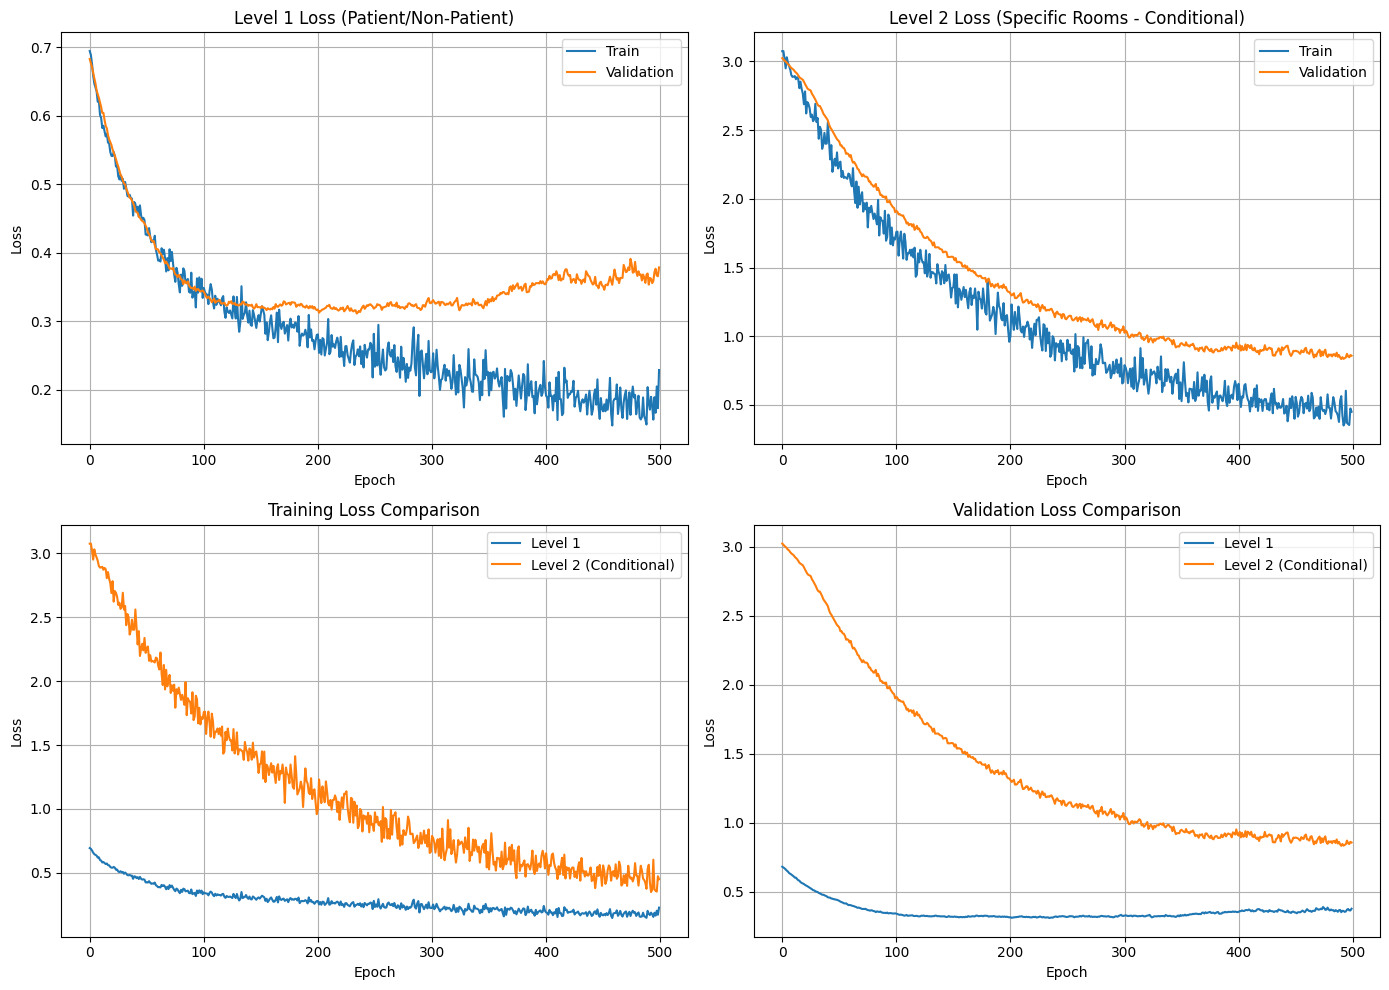


Loss curves saved as 'mlp_multihead_conditional_loss_curves.png'


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import pandas as pd

# =========================
# FEATURE & LABEL (NUMPY)
# =========================
X = feat.drop(columns=['window_start', 'room']).values
y = feat['room'].values

print("Data shape:", X.shape)

# =========================
# FILTER MIN SAMPLE PER CLASS
# =========================
min_samples = 5
unique, counts = np.unique(y, return_counts=True)
valid_rooms = unique[counts >= min_samples]

mask = np.isin(y, valid_rooms)
X = X[mask]
y = y[mask]

print("After filtering:", X.shape)

# =========================
# DEFINISI HIERARKI BARU
# =========================
# patient_rooms = ['201', '202', '208', '203', '204', '205', '206', '207', '209', '210']
patient_rooms = ['201', '208', '210', '213', '511', '512', '513', '515', '520', '522', '523']

def get_room_category(room):
    return 'Patient Room' if str(room) in patient_rooms else 'Non-Patient Room'

y_level1 = np.array([get_room_category(r) for r in y])

# =========================
# LABEL ENCODING
# =========================
le_level1 = LabelEncoder()
y_level1_enc = le_level1.fit_transform(y_level1)

# Level 2: encode semua room (untuk indexing)
le_level2 = LabelEncoder()
y_level2_enc = le_level2.fit_transform(y)

# =========================
# SPLIT DENGAN VALIDATION
# =========================
sss_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
for train_idx, temp_idx in sss_1.split(X, y_level1_enc):
    X_train = X[train_idx]
    y_l1_train = y_level1_enc[train_idx]
    y_l2_train = y_level2_enc[train_idx]
    y_train = y[train_idx]
    
    X_temp = X[temp_idx]
    y_l1_temp = y_level1_enc[temp_idx]
    y_l2_temp = y_level2_enc[temp_idx]
    y_temp = y[temp_idx]

sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=2/3, random_state=42)
for val_idx, test_idx in sss_2.split(X_temp, y_l1_temp):
    X_val = X_temp[val_idx]
    y_l1_val = y_l1_temp[val_idx]
    y_l2_val = y_l2_temp[val_idx]
    y_val = y_temp[val_idx]
    
    X_test = X_temp[test_idx]
    y_l1_test = y_l1_temp[test_idx]
    y_l2_test = y_l2_temp[test_idx]
    y_test = y_temp[test_idx]

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# =========================
# SCALING
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# =========================
# MULTI-HEAD MLP WITH CONDITIONAL LOSS
# =========================
class MultiHeadMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, n_classes_l1, n_classes_l2):
        super().__init__()

        # ===== Shared backbone (lebih kecil & stabil) =====
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),   # stabilisasi distribusi
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # ===== Head Level 1 (lebih sederhana) =====
        self.head_l1 = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[1] // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dims[1] // 2, n_classes_l1)
        )

        # ===== Head Level 2 (regularisasi lebih kuat) =====
        self.head_l2 = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[1] // 2),
            nn.ReLU(),
            nn.Dropout(0.4),   # lebih besar karena kelas lebih banyak
            nn.Linear(hidden_dims[1] // 2, n_classes_l2)
        )

    def forward(self, x):
        h = self.shared(x)
        out_l1 = self.head_l1(h)
        out_l2 = self.head_l2(h)
        return out_l1, out_l2


def train_multihead_conditional(X_train, y_l1_train, y_l2_train, X_val, y_l1_val, y_l2_val, 
                               n_classes_l1, n_classes_l2, patient_room_idx, 
                               epochs=500, batch_size=32, lr=0.0001):
    """Train Multi-Head MLP with Conditional Loss"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_l1_train_t = torch.LongTensor(y_l1_train).to(device)
    y_l2_train_t = torch.LongTensor(y_l2_train).to(device)
    
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_l1_val_t = torch.LongTensor(y_l1_val).to(device)
    y_l2_val_t = torch.LongTensor(y_l2_val).to(device)
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_t, y_l1_train_t, y_l2_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Model
    input_dim = X_train.shape[1]
    model = MultiHeadMLP(input_dim, [100, 50], n_classes_l1, n_classes_l2).to(device)
    
    print(f"\nMulti-Head Model Architecture:")
    print(f"Input: {input_dim} features")
    print(f"Shared Hidden Layer 1: 100 neurons (ReLU + Dropout 0.2)")
    print(f"Shared Hidden Layer 2: 50 neurons (ReLU + Dropout 0.2)")
    print(f"├─ Output Head 1 (Level 1): {n_classes_l1} classes (Patient/Non-Patient)")
    print(f"└─ Output Head 2 (Level 2): {n_classes_l2} classes (Specific Rooms)")
    print(f"\n⚠️  Conditional Loss: Head 2 loss ONLY computed for Patient Room samples")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training
    train_losses_l1 = []
    train_losses_l2 = []
    val_losses_l1 = []
    val_losses_l2 = []
    best_val_loss = float('inf')
    patience = 1000
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss_l1 = 0
        epoch_loss_l2 = 0
        n_batches_l2 = 0
        
        for X_batch, y_l1_batch, y_l2_batch in train_loader:
            optimizer.zero_grad()
            
            out_l1, out_l2 = model(X_batch)
            
            # Level 1 loss: ALWAYS computed
            loss_l1 = criterion(out_l1, y_l1_batch)
            
            # Level 2 loss: CONDITIONAL (only for Patient Room samples)
            patient_mask = (y_l1_batch == patient_room_idx)
            
            if patient_mask.sum() > 0:
                loss_l2 = criterion(out_l2[patient_mask], y_l2_batch[patient_mask])
                epoch_loss_l2 += loss_l2.item()
                n_batches_l2 += 1
            else:
                loss_l2 = 0
            
            # Combined loss
            total_loss = loss_l1 + loss_l2
            
            total_loss.backward()
            optimizer.step()
            
            epoch_loss_l1 += loss_l1.item()
        
        train_losses_l1.append(epoch_loss_l1 / len(train_loader))
        train_losses_l2.append(epoch_loss_l2 / n_batches_l2 if n_batches_l2 > 0 else 0)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out_l1, val_out_l2 = model(X_val_t)
            
            val_loss_l1 = criterion(val_out_l1, y_l1_val_t).item()
            
            # Conditional validation loss for L2
            patient_mask_val = (y_l1_val_t == patient_room_idx)
            if patient_mask_val.sum() > 0:
                val_loss_l2 = criterion(val_out_l2[patient_mask_val], y_l2_val_t[patient_mask_val]).item()
            else:
                val_loss_l2 = 0
            
            val_losses_l1.append(val_loss_l1)
            val_losses_l2.append(val_loss_l2)
            
            val_loss_total = val_loss_l1 + val_loss_l2
        
        # Early stopping
        if val_loss_total < best_val_loss:
            best_val_loss = val_loss_total
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}: Train L1={train_losses_l1[-1]:.4f}, L2={train_losses_l2[-1]:.4f} | Val L1={val_loss_l1:.4f}, L2={val_loss_l2:.4f}")
    
    loss_curves = {
        'train_l1': train_losses_l1,
        'train_l2': train_losses_l2,
        'val_l1': val_losses_l1,
        'val_l2': val_losses_l2
    }
    
    return model, loss_curves

def predict_multihead(model, X):
    """Predict using Multi-Head model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        X_t = torch.FloatTensor(X).to(device)
        out_l1, out_l2 = model(X_t)
        
        _, pred_l1 = torch.max(out_l1, 1)
        _, pred_l2 = torch.max(out_l2, 1)
        
        return pred_l1.cpu().numpy(), pred_l2.cpu().numpy()

# =========================
# SKLEARN MODEL FUNCTION
# =========================
def create_model(name):
    if name == "DT":
        return DecisionTreeClassifier(random_state=42)
    elif name == "RF":
        return RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    elif name == "HGBC":
        return HistGradientBoostingClassifier(random_state=42)
    elif name == "LGBM":
        return lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42, verbose=-1)
    elif name == "CatBoost":
        return CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, verbose=0, random_state=42)
    elif name == "XGBoost":
        return XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric='mlogloss', random_state=42)

# =========================
# TRAINING & EVALUATION
# =========================
all_results = []
mlp_loss_curves = {}
model_names = ["DT", "RF", "HGBC", "LGBM", "CatBoost", "XGBoost", "MLP"]

for model_name in model_names:
    print(f"\n{'='*60}\nModel: {model_name}\n{'='*60}")
    
    if model_name == "MLP":
        # Multi-Head PyTorch MLP with Conditional Loss
        print("Training Multi-Head PyTorch MLP with Conditional Loss...")
        n_classes_l1 = len(np.unique(y_l1_train))
        n_classes_l2 = len(np.unique(y_l2_train))
        patient_room_idx = le_level1.transform(['Patient Room'])[0]
        
        model, loss_curves = train_multihead_conditional(
            X_train_scaled, y_l1_train, y_l2_train,
            X_val_scaled, y_l1_val, y_l2_val,
            n_classes_l1, n_classes_l2, patient_room_idx
        )
        
        mlp_loss_curves.update(loss_curves)
        
        # Prediction function
        def predict_hierarchical(X_input):
            y_l1_pred, y_l2_pred = predict_multihead(model, X_input)
            
            # Decode predictions
            y_pred_rooms = []
            for i in range(len(y_l1_pred)):
                if le_level1.inverse_transform([y_l1_pred[i]])[0] == 'Patient Room':
                    # Use level 2 prediction for patient rooms
                    room = le_level2.inverse_transform([y_l2_pred[i]])[0]
                else:
                    # For non-patient room
                    room = 'Non-Patient Room'
                y_pred_rooms.append(room)
            
            return y_l1_pred, np.array(y_pred_rooms)
        
        X_val_use = X_val_scaled
        X_test_use = X_test_scaled
        
    else:
        # Sklearn models (hierarchical approach)
        clf_l1 = create_model(model_name)
        clf_l1.fit(X_train, y_l1_train)
        
        patient_train_mask = y_l1_train == le_level1.transform(['Patient Room'])[0]
        clf_l2 = create_model(model_name)
        clf_l2.fit(X_train[patient_train_mask], y_l2_train[patient_train_mask])
        
        def predict_hierarchical(X_input):
            y_l1_pred = clf_l1.predict(X_input)
            y_pred_rooms = []
            
            for i, l1_pred in enumerate(y_l1_pred):
                if le_level1.inverse_transform([l1_pred])[0] == 'Patient Room':
                    l2_pred = clf_l2.predict(X_input[i:i+1])[0]
                    room = le_level2.inverse_transform([l2_pred])[0]
                else:
                    room = 'Non-Patient Room'
                y_pred_rooms.append(room)
            
            return y_l1_pred, np.array(y_pred_rooms)
        
        X_val_use = X_val
        X_test_use = X_test
    
    # ==========================================
    # EVALUASI VALIDATION
    # ==========================================
    y_l1_val_pred, y_val_pred = predict_hierarchical(X_val_use)
    
    y_val_adjusted = y_val.copy()
    non_patient_mask_val = y_l1_val == le_level1.transform(['Non-Patient Room'])[0]
    y_val_adjusted[non_patient_mask_val] = 'Non-Patient Room'
    
    # All samples
    all_results.append({
        'model': model_name, 'set': 'Validation', 'eval_type': 'All samples',
        'n_samples': len(y_val),
        'l1_acc': accuracy_score(y_l1_val, y_l1_val_pred),
        'l1_f1': f1_score(y_l1_val, y_l1_val_pred, average='weighted'),
        'l2_acc': accuracy_score(y_val_adjusted, y_val_pred),
        'l2_precision': precision_score(y_val_adjusted, y_val_pred, average='weighted', zero_division=0),
        'l2_recall': recall_score(y_val_adjusted, y_val_pred, average='weighted', zero_division=0),
        'l2_f1': f1_score(y_val_adjusted, y_val_pred, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(y_val_adjusted, y_val_pred, average='macro', zero_division=0)
    })
    
    # L1 correct only
    correct_l1_mask_val = (y_l1_val == y_l1_val_pred)
    y_val_adjusted_filtered = y_val_adjusted[correct_l1_mask_val]
    y_val_pred_filtered = y_val_pred[correct_l1_mask_val]
    
    all_results.append({
        'model': model_name, 'set': 'Validation', 'eval_type': 'L1 correct only',
        'n_samples': correct_l1_mask_val.sum(),
        'l1_acc': accuracy_score(y_l1_val, y_l1_val_pred),
        'l1_f1': f1_score(y_l1_val, y_l1_val_pred, average='weighted'),
        'l2_acc': accuracy_score(y_val_adjusted_filtered, y_val_pred_filtered),
        'l2_precision': precision_score(y_val_adjusted_filtered, y_val_pred_filtered, average='weighted', zero_division=0),
        'l2_recall': recall_score(y_val_adjusted_filtered, y_val_pred_filtered, average='weighted', zero_division=0),
        'l2_f1': f1_score(y_val_adjusted_filtered, y_val_pred_filtered, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(y_val_adjusted_filtered, y_val_pred_filtered, average='macro', zero_division=0)
    })
    
    # ==========================================
    # EVALUASI TEST
    # ==========================================
    y_l1_test_pred, y_test_pred = predict_hierarchical(X_test_use)
    
    y_test_adjusted = y_test.copy()
    non_patient_mask_test = y_l1_test == le_level1.transform(['Non-Patient Room'])[0]
    y_test_adjusted[non_patient_mask_test] = 'Non-Patient Room'
    
    # All samples
    all_results.append({
        'model': model_name, 'set': 'Test', 'eval_type': 'All samples',
        'n_samples': len(y_test),
        'l1_acc': accuracy_score(y_l1_test, y_l1_test_pred),
        'l1_f1': f1_score(y_l1_test, y_l1_test_pred, average='weighted'),
        'l2_acc': accuracy_score(y_test_adjusted, y_test_pred),
        'l2_precision': precision_score(y_test_adjusted, y_test_pred, average='weighted', zero_division=0),
        'l2_recall': recall_score(y_test_adjusted, y_test_pred, average='weighted', zero_division=0),
        'l2_f1': f1_score(y_test_adjusted, y_test_pred, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(y_test_adjusted, y_test_pred, average='macro', zero_division=0)
    })
    
    # L1 correct only
    correct_l1_mask_test = (y_l1_test == y_l1_test_pred)
    y_test_adjusted_filtered = y_test_adjusted[correct_l1_mask_test]
    y_test_pred_filtered = y_test_pred[correct_l1_mask_test]
    
    all_results.append({
        'model': model_name, 'set': 'Test', 'eval_type': 'L1 correct only',
        'n_samples': correct_l1_mask_test.sum(),
        'l1_acc': accuracy_score(y_l1_test, y_l1_test_pred),
        'l1_f1': f1_score(y_l1_test, y_l1_test_pred, average='weighted'),
        'l2_acc': accuracy_score(y_test_adjusted_filtered, y_test_pred_filtered),
        'l2_precision': precision_score(y_test_adjusted_filtered, y_test_pred_filtered, average='weighted', zero_division=0),
        'l2_recall': recall_score(y_test_adjusted_filtered, y_test_pred_filtered, average='weighted', zero_division=0),
        'l2_f1': f1_score(y_test_adjusted_filtered, y_test_pred_filtered, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(y_test_adjusted_filtered, y_test_pred_filtered, average='macro', zero_division=0)
    })
    
    print(f"\nVal (All)       - L1: {all_results[-4]['l1_acc']:.4f}, L2: {all_results[-4]['l2_acc']:.4f}, F1: {all_results[-4]['l2_f1_macro']:.4f}")
    print(f"Val (L1 Correct)- L1: {all_results[-3]['l1_acc']:.4f}, L2: {all_results[-3]['l2_acc']:.4f}, F1: {all_results[-3]['l2_f1_macro']:.4f}")
    print(f"Test (All)      - L1: {all_results[-2]['l1_acc']:.4f}, L2: {all_results[-2]['l2_acc']:.4f}, F1: {all_results[-2]['l2_f1_macro']:.4f}")
    print(f"Test (L1 Correct)- L1: {all_results[-1]['l1_acc']:.4f}, L2: {all_results[-1]['l2_acc']:.4f}, F1: {all_results[-1]['l2_f1_macro']:.4f}")

# =========================
# DISPLAY RESULTS
# =========================
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("VALIDATION - ALL SAMPLES")
print("="*80)
print(results_df[(results_df['set'] == 'Validation') & (results_df['eval_type'] == 'All samples')].sort_values('l2_f1_macro', ascending=False))

print("\n" + "="*80)
print("TEST - ALL SAMPLES")
print("="*80)
print(results_df[(results_df['set'] == 'Test') & (results_df['eval_type'] == 'All samples')].sort_values('l2_f1_macro', ascending=False))

# =========================
# PLOT MLP LOSS CURVES
# =========================
import matplotlib.pyplot as plt

if 'train_l1' in mlp_loss_curves:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].plot(mlp_loss_curves['train_l1'], label='Train')
    axes[0, 0].plot(mlp_loss_curves['val_l1'], label='Validation')
    axes[0, 0].set_title('Level 1 Loss (Patient/Non-Patient)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(mlp_loss_curves['train_l2'], label='Train')
    axes[0, 1].plot(mlp_loss_curves['val_l2'], label='Validation')
    axes[0, 1].set_title('Level 2 Loss (Specific Rooms - Conditional)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(mlp_loss_curves['train_l1'], label='Level 1')
    axes[1, 0].plot(mlp_loss_curves['train_l2'], label='Level 2 (Conditional)')
    axes[1, 0].set_title('Training Loss Comparison')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(mlp_loss_curves['val_l1'], label='Level 1')
    axes[1, 1].plot(mlp_loss_curves['val_l2'], label='Level 2 (Conditional)')
    axes[1, 1].set_title('Validation Loss Comparison')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)a
    
    plt.tight_layout()
    plt.savefig('mlp_multihead_conditional_loss_curves.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    print("\nLoss curves saved as 'mlp_multihead_conditional_loss_curves.png'")

In [24]:
results_df

,model,set,eval_type,n_samples,l1_acc,l1_f1,l2_acc,l2_precision,l2_recall,l2_f1,l2_f1_macro
0,DT,Validation,All samples,71,0.915493,0.915493,0.901408,0.887324,0.901408,0.892019,0.585892
1,DT,Validation,L1 correct only,65,0.915493,0.915493,0.984615,0.984615,0.984615,0.984615,0.800000
2,DT,Test,All samples,142,0.915493,0.916576,0.852113,0.861041,0.852113,0.846779,0.472907
3,DT,Test,L1 correct only,130,0.915493,0.916576,0.930769,0.916550,0.930769,0.920000,0.557576
4,RF,Validation,All samples,71,0.859155,0.843470,0.859155,0.787726,0.859155,0.819752,0.468615
5,RF,Validation,L1 correct only,61,0.859155,0.843470,1.000000,1.000000,1.000000,1.000000,1.000000
6,RF,Test,All samples,142,0.901408,0.894864,0.873239,0.802967,0.873239,0.833411,0.378592
7,RF,Test,L1 correct only,128,0.901408,0.894864,0.968750,0.946875,0.968750,0.955946,0.662698
8,HGBC,Validation,All samples,71,0.901408,0.896757,0.873239,0.836854,0.873239,0.852706,0.431522
9,HGBC,Validation,L1 correct only,64,0.901408,0.896757,0.968750,0.968750,0.968750,0.968750,0.666667


In [25]:
# =========================
# PLOT MLP LOSS CURVES
# =========================
import matplotlib.pyplot as plt

if 'MLP_L1_train' in mlp_loss_curves:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Level 1 Train
    axes[0, 0].plot(mlp_loss_curves['MLP_L1_train'])
    axes[0, 0].set_title('MLP Level 1 - Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)
    
    # Level 1 Val
    axes[0, 1].plot(mlp_loss_curves['MLP_L1_val'])
    axes[0, 1].set_title('MLP Level 1 - Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True)
    
    # Level 2 Train
    axes[1, 0].plot(mlp_loss_curves['MLP_L2_train'])
    axes[1, 0].set_title('MLP Level 2 - Training Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True)
    
    # Level 2 Val
    axes[1, 1].plot(mlp_loss_curves['MLP_L2_val'])
    axes[1, 1].set_title('MLP Level 2 - Validation Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('mlp_pytorch_loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nLoss curves saved as 'mlp_pytorch_loss_curves.png'")

# =========================
# PRINT ARCHITECTURE
# =========================
print("\n" + "="*80)
print("PYTORCH MLP ARCHITECTURE")
print("="*80)
print(f"Input: {X.shape[1]} features")
print(f"Hidden Layer 1: 100 neurons (ReLU + Dropout 0.2)")
print(f"Hidden Layer 2: 50 neurons (ReLU + Dropout 0.2)")
print(f"Output Level 1: {len(np.unique(y_l1_train))} classes")
print(f"Output Level 2: {len(np.unique(y[patient_mask]))} classes")


PYTORCH MLP ARCHITECTURE
Input: 78 features
Hidden Layer 1: 100 neurons (ReLU + Dropout 0.2)
Hidden Layer 2: 50 neurons (ReLU + Dropout 0.2)
Output Level 1: 2 classes


NameError: name 'patient_mask' is not defined

In [26]:
import matplotlib.pyplot as plt

if 'MLP_L1' in mlp_loss_curves:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Level 1
    axes[0].plot(mlp_loss_curves['MLP_L1'])
    axes[0].set_title('MLP Level 1 Training Loss')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    
    # Plot Level 2
    axes[1].plot(mlp_loss_curves['MLP_L2'])
    axes[1].set_title('MLP Level 2 Training Loss')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('mlp_loss_curves.png', dpi=300, bbox_inches='tight')  # SIMPAN GAMBAR
    plt.show()
    
    print("\nLoss curves saved as 'mlp_loss_curves.png'")

### BigGRU

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [63]:
class BiGRUMultiHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes_l1, n_classes_l2):
        super(BiGRUMultiHead, self).__init__()
        
        # 1. Bi-Directional GRU
        self.gru = nn.GRU(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=2,           # 2 stacked layers
            batch_first=True, 
            bidirectional=True,     # Bi-Directional
            dropout=0.5             # Dropout between GRU layers
        )
        
        # 2. Stabilization (Batch Norm + Dropout)
        self.bn = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(0.5)
        
        self.head_l1 = nn.Linear(hidden_dim * 2, n_classes_l1)
        self.head_l2 = nn.Linear(hidden_dim * 2, n_classes_l2)
        
    def forward(self, x):
        # x shape: [Batch_Size, n_features]
        x = x.unsqueeze(1) 
        
        # GRU Forward
        # out shape: [Batch, Seq_Len, Hidden*2]
        # h_n shape: [Num_Layers*2, Batch, Hidden]
        out, h_n = self.gru(x)
        
        # Reshape to [Batch, Hidden*2]
        features = out[:, -1, :]
        
        # Apply Norm and Dropout
        features = self.bn(features)
        features = self.dropout(features)
        
        # Output Heads
        out_l1 = self.head_l1(features)
        out_l2 = self.head_l2(features)
        
        return out_l1, out_l2

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
INPUT_DIM = X_train_scaled.shape[1]
HIDDEN_DIM = 128
N_CLASSES_L1 = len(np.unique(y_l1_train))
N_CLASSES_L2 = len(np.unique(y_l2_train))
PATIENT_ROOM_IDX = le_level1.transform(['Patient Room'])[0]

model_bigru = BiGRUMultiHead(INPUT_DIM, HIDDEN_DIM, N_CLASSES_L1, N_CLASSES_L2).to(device)

In [68]:
print(f"\nBiGRU Architecture:")
print(f"Input: {INPUT_DIM} features (Reshaped to Seq_Len=1)")
print(f"GRU: Hidden={HIDDEN_DIM}, Layers=2, Bidirectional=True")
print(f"Backbone Output: {HIDDEN_DIM*2} dimensions")


BiGRU Architecture:
Input: 78 features (Reshaped to Seq_Len=1)
GRU: Hidden=32, Layers=2, Bidirectional=True
Backbone Output: 64 dimensions


In [69]:
trained_bigru, bigru_losses = train_multihead_conditional(
    X_train_scaled, y_l1_train, y_l2_train,
    X_val_scaled, y_l1_val, y_l2_val,
    N_CLASSES_L1, N_CLASSES_L2, PATIENT_ROOM_IDX,
    epochs=500, batch_size=64, lr=0.0005 
)

Using device: cpu

Multi-Head Model Architecture:
Input: 78 features
Shared Hidden Layer 1: 100 neurons (ReLU + Dropout 0.2)
Shared Hidden Layer 2: 50 neurons (ReLU + Dropout 0.2)
├─ Output Head 1 (Level 1): 2 classes (Patient/Non-Patient)
└─ Output Head 2 (Level 2): 20 classes (Specific Rooms)

⚠️  Conditional Loss: Head 2 loss ONLY computed for Patient Room samples
Epoch 50: Train L1=0.2837, L2=1.0358 | Val L1=0.3336, L2=1.1928
Epoch 100: Train L1=0.1881, L2=0.6842 | Val L1=0.3456, L2=0.7915
Epoch 150: Train L1=0.1121, L2=0.4799 | Val L1=0.3836, L2=0.5944
Epoch 200: Train L1=0.1126, L2=0.2554 | Val L1=0.3719, L2=0.6070
Epoch 250: Train L1=0.0944, L2=0.2788 | Val L1=0.4295, L2=0.5539
Epoch 300: Train L1=0.0535, L2=0.1516 | Val L1=0.4520, L2=0.5610
Epoch 350: Train L1=0.0515, L2=0.1586 | Val L1=0.5726, L2=0.6123
Epoch 400: Train L1=0.0510, L2=0.1738 | Val L1=0.5513, L2=0.6290
Epoch 450: Train L1=0.0572, L2=0.1044 | Val L1=0.5588, L2=0.8255
Epoch 500: Train L1=0.0627, L2=0.0657 | Val L1

In [70]:
def predict_and_score(model, X_data, y_l1_true, y_l2_true):
    l1_pred, l2_pred = predict_multihead(model, X_data) 
    acc_l1 = accuracy_score(y_l1_true, l1_pred)
    f1_l1 = f1_score(y_l1_true, l1_pred, average='weighted')
    
    final_preds = []
    final_true = []

    for i in range(len(l1_pred)):
        final_preds.append(l2_pred[i])
        final_true.append(y_l2_true[i])
        
    acc_l2 = accuracy_score(final_true, final_preds)
    f1_l2 = f1_score(final_true, final_preds, average='macro')
    
    return acc_l1, f1_l1, acc_l2, f1_l2

In [71]:
val_acc1, val_f1_1, val_acc2, val_f1_2 = predict_and_score(trained_bigru, X_val_scaled, y_l1_val, y_l2_val)
test_acc1, test_f1_1, test_acc2, test_f1_2 = predict_and_score(trained_bigru, X_test_scaled, y_l1_test, y_l2_test)

print("\n" + "="*40)
print("BiGRU FINAL RESULTS")
print("="*40)
print(f"Validation | L1 Acc: {val_acc1:.4f} | L2 F1-Macro: {val_f1_2:.4f}")
print(f"Test       | L1 Acc: {test_acc1:.4f} | L2 F1-Macro: {test_f1_2:.4f}")


BiGRU FINAL RESULTS
Validation | L1 Acc: 0.9296 | L2 F1-Macro: 0.2371
Test       | L1 Acc: 0.8873 | L2 F1-Macro: 0.1359


In [72]:
def get_bigru_metrics(model, X, y_l1_true, y_l2_true, set_name):
    l1_pred, l2_pred = predict_multihead(model, X)
    l1_pred = l1_pred.astype(int)
    l2_pred = l2_pred.astype(int)
    
    l1_pred_str = le_level1.inverse_transform(l1_pred)
    l2_pred_str = le_level2.inverse_transform(l2_pred)
    
    final_l2_pred_str = []
    for i in range(len(l1_pred)):
        if l1_pred_str[i] == 'Non-Patient Room':
            final_l2_pred_str.append('Non-Patient Room')
        else:
            final_l2_pred_str.append(l2_pred_str[i])

    y_l1_true_str = le_level1.inverse_transform(y_l1_true)
    y_l2_true_str = le_level2.inverse_transform(y_l2_true)
    
    final_l2_true_str = []
    for i in range(len(y_l1_true)):
        if y_l1_true_str[i] == 'Non-Patient Room':
            final_l2_true_str.append('Non-Patient Room')
        else:
            final_l2_true_str.append(y_l2_true_str[i])
    
    rows = []
    
    rows.append({
        'model': 'BiGRU',
        'set': set_name,
        'eval_type': 'All samples',
        'n_samples': len(y_l1_true),
        'l1_acc': accuracy_score(y_l1_true, l1_pred), 
        'l1_f1': f1_score(y_l1_true, l1_pred, average='weighted'),
        'l2_acc': accuracy_score(final_l2_true_str, final_l2_pred_str),
        'l2_precision': precision_score(final_l2_true_str, final_l2_pred_str, average='weighted', zero_division=0),
        'l2_recall': recall_score(final_l2_true_str, final_l2_pred_str, average='weighted', zero_division=0),
        'l2_f1': f1_score(final_l2_true_str, final_l2_pred_str, average='weighted', zero_division=0),
        'l2_f1_macro': f1_score(final_l2_true_str, final_l2_pred_str, average='macro', zero_division=0)
    })
    
    mask = (y_l1_true == l1_pred)
    if mask.sum() > 0:
        true_filt = np.array(final_l2_true_str)[mask]
        pred_filt = np.array(final_l2_pred_str)[mask]
        
        rows.append({
            'model': 'BiGRU',
            'set': set_name,
            'eval_type': 'L1 correct only',
            'n_samples': mask.sum(),
            'l1_acc': 1.0, 
            'l1_f1': 1.0,
            'l2_acc': accuracy_score(true_filt, pred_filt),
            'l2_precision': precision_score(true_filt, pred_filt, average='weighted', zero_division=0),
            'l2_recall': recall_score(true_filt, pred_filt, average='weighted', zero_division=0),
            'l2_f1': f1_score(true_filt, pred_filt, average='weighted', zero_division=0),
            'l2_f1_macro': f1_score(true_filt, pred_filt, average='macro', zero_division=0)
        })
        
    return rows

In [53]:
val_rows = get_bigru_metrics(trained_bigru, X_val_scaled, y_l1_val, y_l2_val, 'Validation')
test_rows = get_bigru_metrics(trained_bigru, X_test_scaled, y_l1_test, y_l2_test, 'Test')
bigru_df = pd.DataFrame(val_rows + test_rows)
results_df = pd.concat([results_df, bigru_df], ignore_index=True)

print("\n" + "="*80)
print("VALIDATION - ALL SAMPLES (Sorted by Macro F1)")
print("="*80)
display(results_df[(results_df['set'] == 'Validation') & (results_df['eval_type'] == 'All samples')].sort_values('l2_f1_macro', ascending=False))

print("\n" + "="*80)
print("TEST - ALL SAMPLES (Sorted by Macro F1)")
print("="*80)
display(results_df[(results_df['set'] == 'Test') & (results_df['eval_type'] == 'All samples')].sort_values('l2_f1_macro', ascending=False))


VALIDATION - ALL SAMPLES (Sorted by Macro F1)


,model,set,eval_type,n_samples,l1_acc,l1_f1,l2_acc,l2_precision,l2_recall,l2_f1,l2_f1_macro
12,LGBM,Validation,All samples,71,0.915493,0.912971,0.915493,0.891581,0.915493,0.901466,0.744216
24,MLP,Validation,All samples,71,0.901408,0.896757,0.901408,0.865023,0.901408,0.880875,0.652570
20,XGBoost,Validation,All samples,71,0.901408,0.900011,0.887324,0.862474,0.887324,0.870650,0.622172
28,BiGRU,Validation,All samples,71,0.887324,0.879844,0.873239,0.843570,0.873239,0.851675,0.599897
0,DT,Validation,All samples,71,0.915493,0.915493,0.901408,0.887324,0.901408,0.892019,0.585892
16,CatBoost,Validation,All samples,71,0.901408,0.896757,0.887324,0.841549,0.887324,0.862766,0.555167
4,RF,Validation,All samples,71,0.859155,0.843470,0.859155,0.787726,0.859155,0.819752,0.468615
8,HGBC,Validation,All samples,71,0.901408,0.896757,0.873239,0.836854,0.873239,0.852706,0.431522



TEST - ALL SAMPLES (Sorted by Macro F1)


,model,set,eval_type,n_samples,l1_acc,l1_f1,l2_acc,l2_precision,l2_recall,l2_f1,l2_f1_macro
22,XGBoost,Test,All samples,142,0.887324,0.888768,0.859155,0.882688,0.859155,0.859947,0.547604
18,CatBoost,Test,All samples,142,0.901408,0.898466,0.866197,0.834602,0.866197,0.845299,0.476318
2,DT,Test,All samples,142,0.915493,0.916576,0.852113,0.861041,0.852113,0.846779,0.472907
30,BiGRU,Test,All samples,142,0.901408,0.898466,0.859155,0.840512,0.859155,0.846038,0.466731
10,HGBC,Test,All samples,142,0.915493,0.914295,0.859155,0.835709,0.859155,0.845459,0.418519
14,LGBM,Test,All samples,142,0.887324,0.887324,0.852113,0.861236,0.852113,0.847686,0.401692
6,RF,Test,All samples,142,0.901408,0.894864,0.873239,0.802967,0.873239,0.833411,0.378592
26,MLP,Test,All samples,142,0.915493,0.911506,0.859155,0.808333,0.859155,0.831600,0.350894


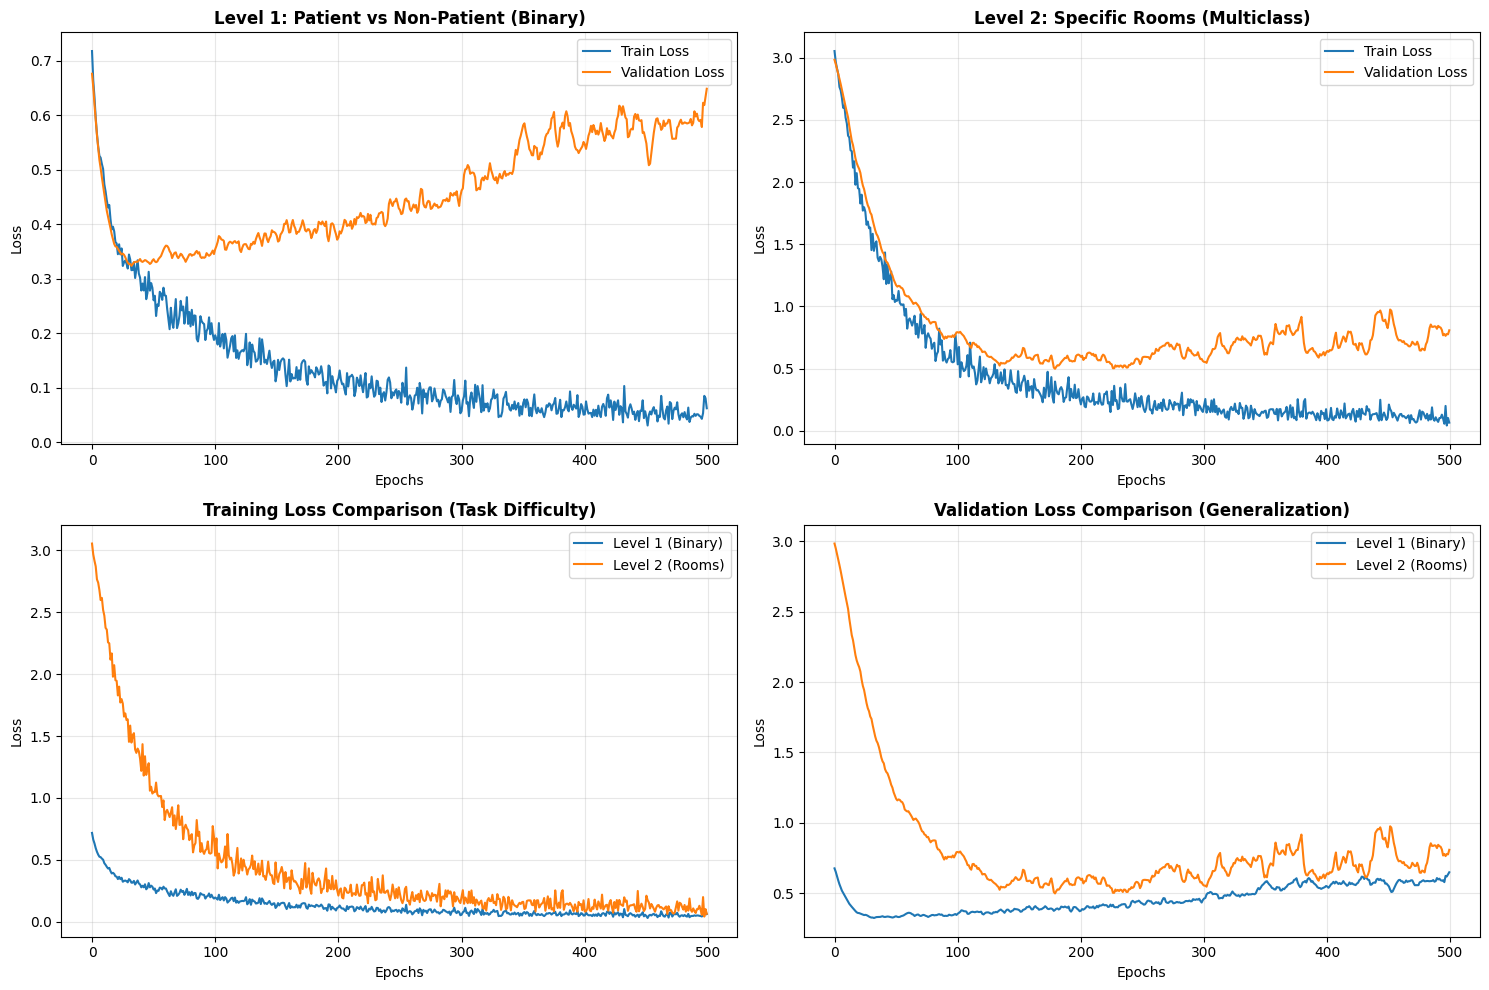

Plot saved as 'bigru_4panel_analysis.png'


In [74]:
history = bigru_losses 

if 'train_l1' in history:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # -------------------------------------------------------
    # PLOT 1: Level 1 (Binary) - Train vs Val
    # Checks for Overfitting in Binary Task
    # -------------------------------------------------------
    axes[0, 0].plot(history['train_l1'], label='Train Loss', color='tab:blue')
    axes[0, 0].plot(history['val_l1'], label='Validation Loss', color='tab:orange')
    axes[0, 0].set_title('Level 1: Patient vs Non-Patient (Binary)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # -------------------------------------------------------
    # PLOT 2: Level 2 (Rooms) - Train vs Val
    # Checks for Overfitting in Room Task
    # -------------------------------------------------------
    axes[0, 1].plot(history['train_l2'], label='Train Loss', color='tab:blue')
    axes[0, 1].plot(history['val_l2'], label='Validation Loss', color='tab:orange')
    axes[0, 1].set_title('Level 2: Specific Rooms (Multiclass)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # -------------------------------------------------------
    # PLOT 3: Training Comparison - L1 vs L2
    # Shows which task is harder to learn
    # -------------------------------------------------------
    axes[1, 0].plot(history['train_l1'], label='Level 1 (Binary)', color='tab:blue')
    axes[1, 0].plot(history['train_l2'], label='Level 2 (Rooms)', color='tab:orange')
    axes[1, 0].set_title('Training Loss Comparison (Task Difficulty)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # -------------------------------------------------------
    # PLOT 4: Validation Comparison - L1 vs L2
    # Shows which task generalizes better
    # -------------------------------------------------------
    axes[1, 1].plot(history['val_l1'], label='Level 1 (Binary)', color='tab:blue')
    axes[1, 1].plot(history['val_l2'], label='Level 2 (Rooms)', color='tab:orange')
    axes[1, 1].set_title('Validation Loss Comparison (Generalization)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('bigru_4panel_analysis.png', dpi=300)
    plt.show()
    print("Plot saved as 'bigru_4panel_analysis.png'")
else:
    print("Error: 'train_l1' key not found in history dictionary. Check your variable name.")

### bilstm

In [ ]:
class BiLSTMMultiHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes_l1, n_classes_l2):
        super(BiLSTMMultiHead, self).__init__()
        
        # 1. Bi-Directional LSTM
        # LSTM returns (output, (h_n, c_n))
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=2,           
            batch_first=True, 
            bidirectional=True
        )
        
        # 2. Stabilization
        self.bn = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(0.5)
        
        # 3. Heads
        self.head_l1 = nn.Linear(hidden_dim * 2, n_classes_l1)
        self.head_l2 = nn.Linear(hidden_dim * 2, n_classes_l2)
        
    def forward(self, x):
        # Reshape [Batch, Features] -> [Batch, 1, Features]
        x = x.unsqueeze(1) 
        
        # LSTM Forward
        # out: [Batch, Seq, Hidden*2]
        # hidden: (h_n, c_n)
        self.lstm.flatten_parameters() # Optimization for fast processing
        out, (h_n, c_n) = self.lstm(x)
        
        # Take last time step features
        features = out[:, -1, :]
        
        # Apply Norm and Dropout
        features = self.bn(features)
        features = self.dropout(features)
        
        return self.head_l1(features), self.head_l2(features)

In [82]:
HIDDEN_DIM_LSTM = 128
model_bilstm = BiLSTMMultiHead(INPUT_DIM, HIDDEN_DIM_LSTM, N_CLASSES_L1, N_CLASSES_L2).to(device)

In [83]:
trained_bilstm, bilstm_losses = train_multihead_conditional(
    X_train_scaled, y_l1_train, y_l2_train,
    X_val_scaled, y_l1_val, y_l2_val,
    N_CLASSES_L1, N_CLASSES_L2, PATIENT_ROOM_IDX,
    epochs=500, batch_size=64, lr=0.0005 
)

Using device: cpu

Multi-Head Model Architecture:
Input: 78 features
Shared Hidden Layer 1: 100 neurons (ReLU + Dropout 0.2)
Shared Hidden Layer 2: 50 neurons (ReLU + Dropout 0.2)
├─ Output Head 1 (Level 1): 2 classes (Patient/Non-Patient)
└─ Output Head 2 (Level 2): 20 classes (Specific Rooms)

⚠️  Conditional Loss: Head 2 loss ONLY computed for Patient Room samples
Epoch 50: Train L1=0.2653, L2=1.2267 | Val L1=0.3268, L2=1.5319
Epoch 100: Train L1=0.2077, L2=0.5320 | Val L1=0.3311, L2=0.7977
Epoch 150: Train L1=0.1167, L2=0.3648 | Val L1=0.3619, L2=0.5470
Epoch 200: Train L1=0.1199, L2=0.3774 | Val L1=0.4160, L2=0.6014
Epoch 250: Train L1=0.1092, L2=0.1438 | Val L1=0.4917, L2=0.6053
Epoch 300: Train L1=0.0849, L2=0.1903 | Val L1=0.5857, L2=0.6026
Epoch 350: Train L1=0.0636, L2=0.1325 | Val L1=0.5947, L2=0.6721
Epoch 400: Train L1=0.0757, L2=0.0984 | Val L1=0.6946, L2=0.8140
Epoch 450: Train L1=0.0452, L2=0.1316 | Val L1=0.7642, L2=0.8669
Epoch 500: Train L1=0.0454, L2=0.1435 | Val L1

In [84]:
val_rows_lstm = get_bigru_metrics(trained_bilstm, X_val_scaled, y_l1_val, y_l2_val, 'Validation')
for row in val_rows_lstm: row['model'] = 'BiLSTM'

test_rows_lstm = get_bigru_metrics(trained_bilstm, X_test_scaled, y_l1_test, y_l2_test, 'Test')
for row in test_rows_lstm: row['model'] = 'BiLSTM'

bilstm_df = pd.DataFrame(val_rows_lstm + test_rows_lstm)
results_df = pd.concat([results_df, bilstm_df], ignore_index=True)

print("\n" + "="*80)
print("TEST RESULTS (Sorted by L2 F1 Macro)")
print("="*80)

display(results_df[(results_df['set'] == 'Test') & (results_df['eval_type'] == 'All samples')].sort_values('l2_f1_macro', ascending=False))


TEST RESULTS (Sorted by L2 F1 Macro)


,model,set,eval_type,n_samples,l1_acc,l1_f1,l2_acc,l2_precision,l2_recall,l2_f1,l2_f1_macro
22,XGBoost,Test,All samples,142,0.887324,0.888768,0.859155,0.882688,0.859155,0.859947,0.547604
18,CatBoost,Test,All samples,142,0.901408,0.898466,0.866197,0.834602,0.866197,0.845299,0.476318
2,DT,Test,All samples,142,0.915493,0.916576,0.852113,0.861041,0.852113,0.846779,0.472907
30,BiGRU,Test,All samples,142,0.901408,0.898466,0.859155,0.840512,0.859155,0.846038,0.466731
10,HGBC,Test,All samples,142,0.915493,0.914295,0.859155,0.835709,0.859155,0.845459,0.418519
14,LGBM,Test,All samples,142,0.887324,0.887324,0.852113,0.861236,0.852113,0.847686,0.401692
34,BiLSTM,Test,All samples,142,0.887324,0.883962,0.859155,0.831026,0.859155,0.842210,0.387011
38,BiLSTM,Test,All samples,142,0.873239,0.869457,0.845070,0.822168,0.845070,0.832631,0.381606
6,RF,Test,All samples,142,0.901408,0.894864,0.873239,0.802967,0.873239,0.833411,0.378592
26,MLP,Test,All samples,142,0.915493,0.911506,0.859155,0.808333,0.859155,0.831600,0.350894


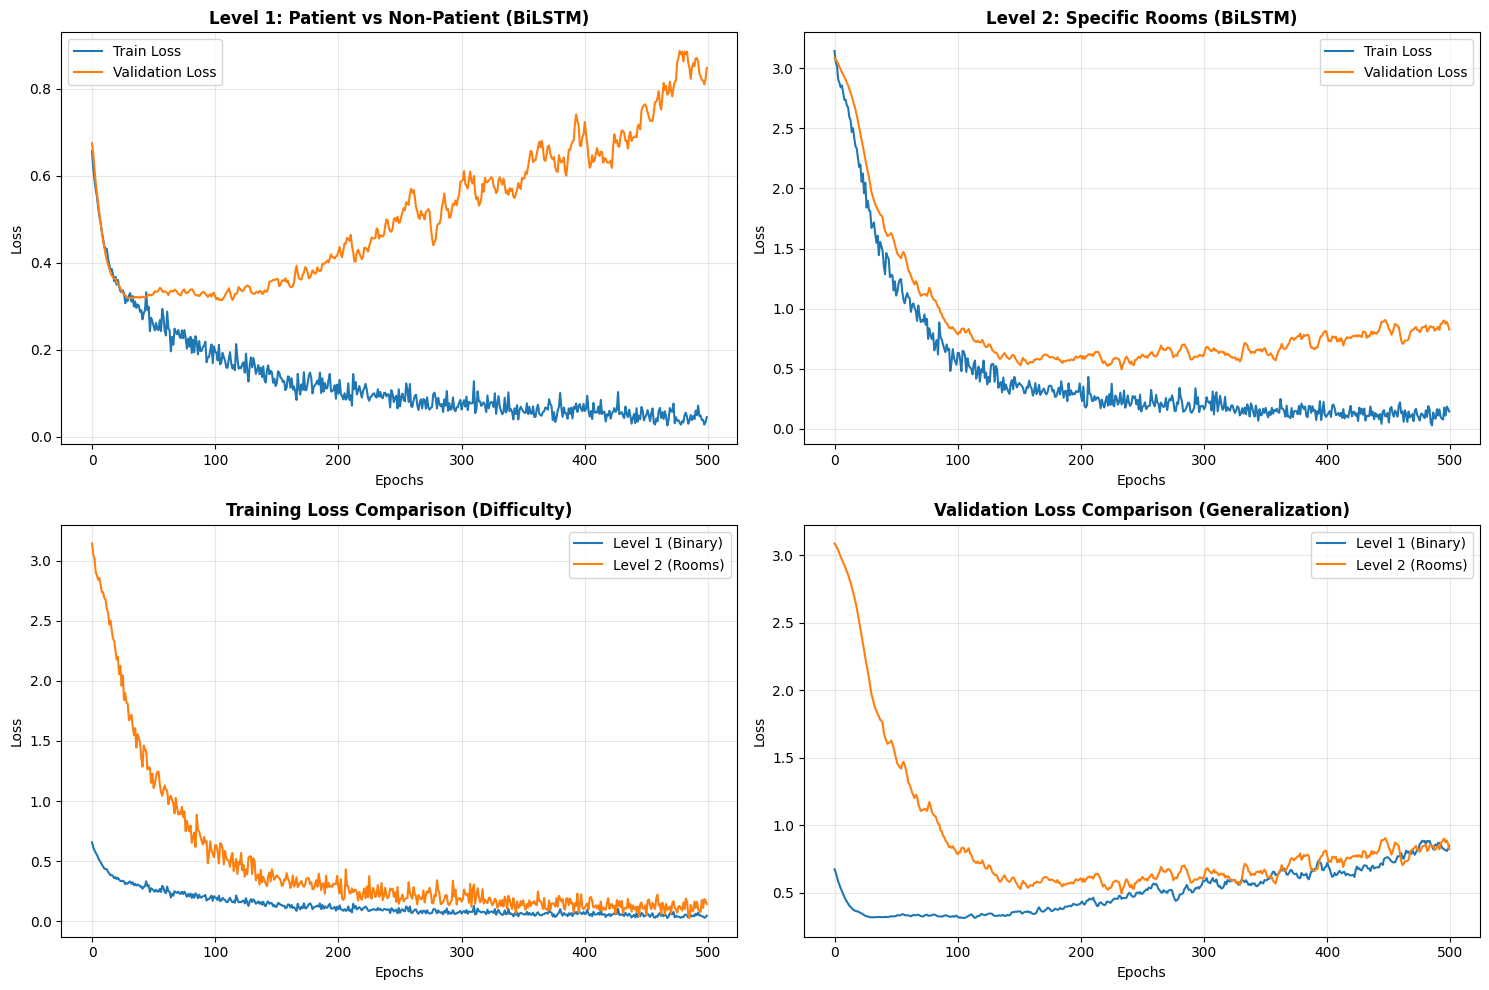

Plot saved as 'bilstm_4panel_analysis.png'


In [85]:
history = bilstm_losses 

if 'train_l1' in history:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # -------------------------------------------------------
    # PLOT 1: Level 1 (Binary) - Train vs Val
    # -------------------------------------------------------
    axes[0, 0].plot(history['train_l1'], label='Train Loss', color='tab:blue')
    axes[0, 0].plot(history['val_l1'], label='Validation Loss', color='tab:orange')
    axes[0, 0].set_title('Level 1: Patient vs Non-Patient (BiLSTM)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # -------------------------------------------------------
    # PLOT 2: Level 2 (Rooms) - Train vs Val
    # -------------------------------------------------------
    axes[0, 1].plot(history['train_l2'], label='Train Loss', color='tab:blue')
    axes[0, 1].plot(history['val_l2'], label='Validation Loss', color='tab:orange')
    axes[0, 1].set_title('Level 2: Specific Rooms (BiLSTM)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # -------------------------------------------------------
    # PLOT 3: Training Comparison - L1 vs L2
    # -------------------------------------------------------
    axes[1, 0].plot(history['train_l1'], label='Level 1 (Binary)', color='tab:blue')
    axes[1, 0].plot(history['train_l2'], label='Level 2 (Rooms)', color='tab:orange')
    axes[1, 0].set_title('Training Loss Comparison (Difficulty)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # -------------------------------------------------------
    # PLOT 4: Validation Comparison - L1 vs L2
    # -------------------------------------------------------
    axes[1, 1].plot(history['val_l1'], label='Level 1 (Binary)', color='tab:blue')
    axes[1, 1].plot(history['val_l2'], label='Level 2 (Rooms)', color='tab:orange')
    axes[1, 1].set_title('Validation Loss Comparison (Generalization)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('bilstm_4panel_analysis.png', dpi=300)
    plt.show()
    print("Plot saved as 'bilstm_4panel_analysis.png'")
else:
    print("Error: History not found. Make sure you ran the training block first.")